# Machine Learning 

In [3]:
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
%matplotlib inline 

# Setting a seaborn style for all graphs 
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, accuracy_score 


In [4]:
df=pd.read_csv('/Users/dasha/Downloads/Files/final_dataframe.csv',parse_dates=['Date Occurred_Time Occurred','Date Occurred','Time Occurred'],index_col=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)




### Preprocessing the dataset for Machine Learning 

- Eliminating missing values  
- Converting variables to appropriate types and categories 



In [5]:
df_null=(df['Victim Age']=='Missing')|(df['Victim Sex']=='Missing') | (df['Victim Descent']=='Missing')
df_clean=df[~df_null]

In [6]:
pd.options.mode.chained_assignment = None

In [7]:
df_clean['Victim Age']=pd.to_numeric(df_clean['Victim Age'])
df_clean[['Victim Sex','Victim Descent','Premise Description']]=df_clean[['Victim Sex','Victim Descent','Premise Description']].apply(lambda x : x.astype('category'))

In [8]:
df_clean.loc[:,'Location ']=df_clean.loc[:,'Location '].str.strip('(')
df_clean.loc[:,'Location ']=df_clean.loc[:,'Location '].str.strip(')')
df_clean['Location ']=df_clean['Location '].str.split(',')
df_clean['Latitude']=df_clean['Location '].apply(lambda x: x[0])
df_clean['Longitude']=df_clean['Location '].apply(lambda x: x[1])
df_clean[['Latitude','Longitude']]=df_clean[['Latitude','Longitude']].astype(float)
df_clean=(df_clean[~(df_clean['Longitude']==0)| ~(df_clean['Latitude']==0)])

### EDA for Machine Learning Purposes 

Is there an effect of the month on crime occurrance? 

Month does not seem to have much a difference, except for beginning and the end of the year. For simplicity will exclude this parameter. 

Text(0,0.5,'Crime Count')

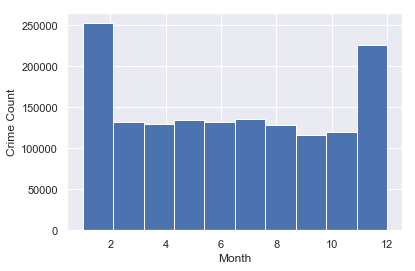

In [9]:
df_clean['Date Occurred_Time Occurred'].dt.month.plot(kind='hist')
plt.xlabel('Month')
plt.ylabel('Crime Count')

Day of the month doesn't seem to have much of a difference either (except at the end and the beginnig of the month)

Text(0,0.5,'Crime Count')

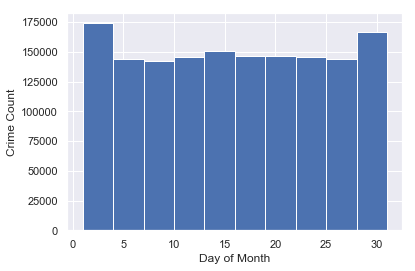

In [10]:
df_clean['Day_of_Month'].plot(kind='hist')
plt.xlabel('Day of Month')
plt.ylabel('Crime Count')

The hour of crime does seem to have a variable distribution (skewed to the later hours in the day)  

Text(0,0.5,'Crime Count')

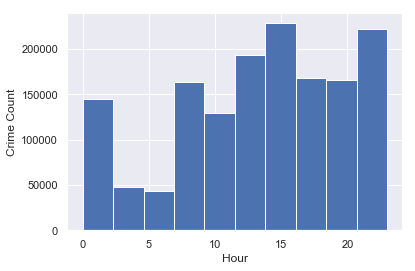

In [11]:
df_clean['Hour'].plot(kind='hist')
plt.xlabel('Hour')
plt.ylabel('Crime Count')

Minutes recorded for the crime seems to fall either into the ':00' or the ':30' timepoints 

Text(0.5,0,'Minute')

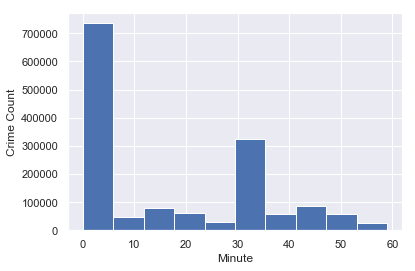

In [12]:
df_clean['Minute'].plot(kind='hist')
plt.ylabel('Crime Count')
plt.xlabel('Minute')

Age has a distribution skewed towards younger ages

Text(0,0.5,'Crime Count')

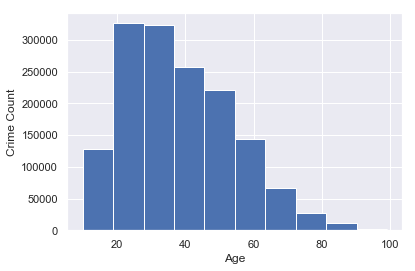

In [13]:
df_clean['Victim Age'].plot(kind='hist')
plt.xlabel('Age')
plt.ylabel('Crime Count')

Crime effect on the different 'Victim Sex' categories is described below. 

In [14]:
df_clean['Victim Sex'].value_counts()

M    750399
F    744831
X     11620
H        60
N         5
-         1
Name: Victim Sex, dtype: int64

Text(0.5,1,'Female')

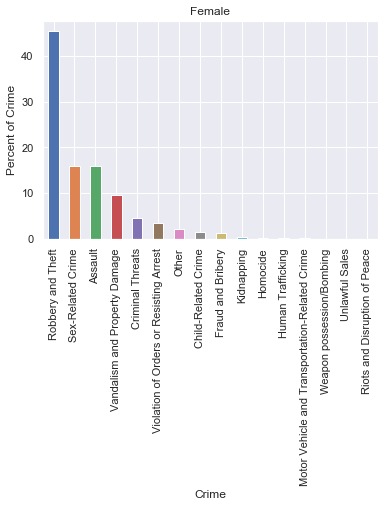

In [15]:
df_sex_female=df_clean[df_clean['Victim Sex']=='F']
((df_sex_female['Crime'].value_counts())/(df_sex_female['Crime'].value_counts().sum())*100).plot(kind='bar')
plt.xlabel('Crime')
plt.ylabel('Percent of Crime')
plt.title('Female')

Text(0.5,1,'Male')

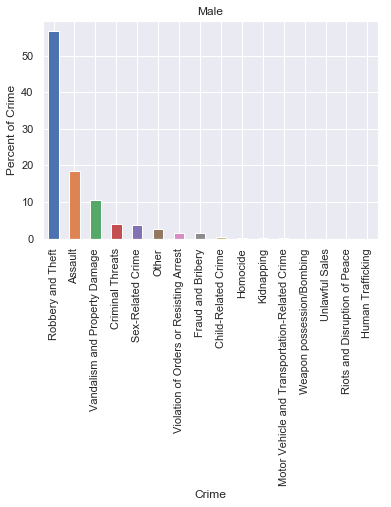

In [16]:
df_sex_male=df_clean[df_clean['Victim Sex']=='M']
((df_sex_male['Crime'].value_counts())/(df_sex_male['Crime'].value_counts().sum())*100).plot(kind='bar')
plt.xlabel('Crime')
plt.ylabel('Percent of Crime')
plt.title('Male')

Text(0.5,1,'Sex=X')

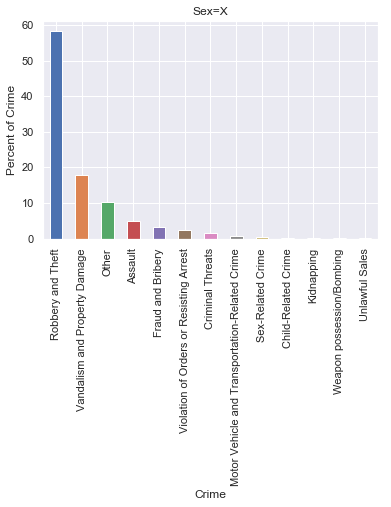

In [17]:
df_sex_x=df_clean[df_clean['Victim Sex']=='X']
count=(((df_sex_x['Crime'].value_counts())/(df_sex_x['Crime'].value_counts().sum())*100))
count.plot(kind='bar')
plt.xlabel('Crime')
plt.ylabel('Percent of Crime')
plt.title('Sex=X')

Text(0.5,1,'Sex=H')

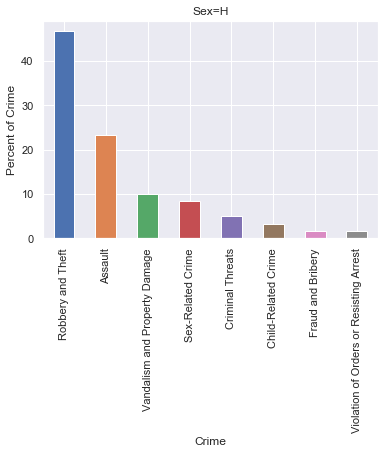

In [18]:
df_sex_h=df_clean[df_clean['Victim Sex']=='H']
((df_sex_h['Crime'].value_counts())/(df_sex_h['Crime'].value_counts().sum())*100).plot(kind='bar')
plt.xlabel('Crime')
plt.ylabel('Percent of Crime')
plt.title('Sex=H')

### Machine Learning 

Loading the necessary packages... 

Machine learning techniques here were focues on districts with rising crime only: Newton, Olympic, Central, Hollenbeck, and Hollywood districts. 

Features taken into consideration are 
- Latitude
- Longitude
- Min_sin
- Min_cos
- Victim Age
- Hour_sin
- Hour_cos
- Victim Sex
- Victim Descent

In [19]:
df_clean_full=df_clean[['Min_sin','Min_cos','Crime','Hour_sin','Hour_cos','Latitude','Longitude','Victim Age','Victim Sex','Victim Descent','Area Name']].copy()
df_clean_full=df_clean[(df_clean['Area Name']=='Olympic')|(df_clean['Area Name']=='Central')|(df_clean['Area Name']=='Newton')|(df_clean['Area Name']=='Hollenbeck')|(df_clean['Area Name']=='Hollywood')]
df_clean_full=df_clean_full[(df_clean_full['Crime']=='Assault')|(df_clean_full['Crime']=='Robbery and Theft')]
df_clean_full_y=df_clean_full[['Crime']]
df_clean_full=pd.get_dummies(df_clean_full[['Latitude','Longitude','Min_sin','Min_cos','Victim Age','Hour_sin','Hour_cos','Victim Sex','Victim Descent']])
df_clean_full=pd.concat([df_clean_full_y,df_clean_full],axis=1)

def dummy_creator(data):
    if data==('Assault'): 
        return 1
    else: 
        return 0 
    
df_clean_full['Crime']=df_clean_full['Crime'].apply(dummy_creator)
df_clean_full.head()

,Crime,Latitude,Longitude,Min_sin,Min_cos,Victim Age,Hour_sin,Hour_cos,Victim Sex_-,Victim Sex_F,...,Victim Descent_K,Victim Descent_L,Victim Descent_O,Victim Descent_P,Victim Descent_S,Victim Descent_U,Victim Descent_V,Victim Descent_W,Victim Descent_X,Victim Descent_Z
16,1,34.0431,-118.2536,-1.959435e-15,1.0,23.0,-0.500000,-0.866025,0,0,...,0,0,0,0,0,0,0,0,0,0
18,1,34.0352,-118.2583,0.000000e+00,1.0,18.0,-0.707107,-0.707107,0,1,...,0,0,0,0,0,0,0,0,0,0
19,0,34.0480,-118.2577,-1.715001e-14,1.0,25.0,-0.965926,-0.258819,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,34.0517,-118.2456,-9.797174e-16,1.0,20.0,-0.866025,0.500000,0,1,...,0,0,0,0,0,0,0,0,0,0
24,1,34.0435,-118.2471,-8.575004e-15,1.0,32.0,-0.258819,0.965926,0,1,...,0,0,0,0,0,0,0,0,0,0


The two categries for classification ('Assault' and 'Robbery and Theft') were unbalanced and were fixed through upsampling  

In [20]:
majority=df_clean_full[df_clean_full['Crime']==0]
minority=df_clean_full[df_clean_full['Crime']==1]
print('majority class shape', len(majority))
print('minority class shape',len(minority))


majority class shape 149521
minority class shape 70000


In [21]:
majority_upscale=resample(majority,replace=False,n_samples=len(minority),random_state=42)

In [22]:
scaled_df=pd.concat([minority,majority_upscale])

Multiple machine learning models were utilized including: DecisionTreeClassifier, ExtraTreesClassifier, MLPClassifier, AdaBoostClassifier, RandomForestClassifier, and XGBClassifier. 

XGBClassifier showed the best performace and was used as the final model. 

xgb=XGBClassifier()  
param_grid={'n_estimators':[50,150],'max_depth':[5,10],'subsample':[.5,.6,.7,.8,.9]}  
xgb=GridSearchCV(xgb,param_grid=param_grid,cv=5)   
xgb.fit(X_train,y_train)  
xgb.best_params_   

Best parameters n_estimators: 150, max_depth: 10, subsample: .8   
model with 40 n_estimators yeilded the same result and therefore, 40 n_estimators were used in the following    calculations   


##### Carrying out the XBGClassification... 

In [23]:
X_scaled=scaled_df.drop(columns='Crime').values
Y_scaled=scaled_df['Crime'].values 

Creating test and train sets ...

In [24]:
X_train_s,X_test_s,y_train_s,y_test_s = train_test_split(X_scaled,Y_scaled,test_size=.3, random_state=42,stratify=Y_scaled)

Fitting the model ...

In [25]:
xgb_s=XGBClassifier(n_estimators=40,max_depth=10,eta=.3,subsample=.8)
xgb_s.fit(X_train_s,y_train_s)
xgb_s.score(X_test_s,y_test_s)
y_pred_s=xgb_s.predict(X_test_s)

ROC/AUC score 

In [26]:
# ROC/AUC score 
y_pred_proba_s=xgb_s.predict_proba(X_test_s)[:,1]
print('ROC/AUC Score: ',roc_auc_score(y_test_s,y_pred_proba_s)*100)

ROC/AUC Score:  73.65153854875282


ROC curve

Text(0.5,1,'ROC curve')

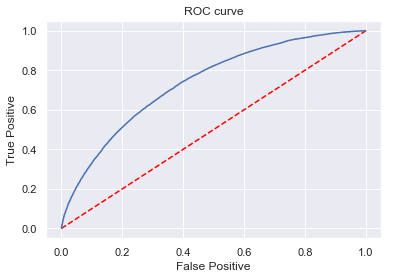

In [27]:
fpr,tpr,thresholds=roc_curve(y_test_s,y_pred_proba_s)
plt.plot([0,1],[0,1],'k--',color='red')
plt.plot(fpr,tpr)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC curve')

Confusion Matrix

In [28]:
 xgb_df_s=pd.DataFrame({'true':y_test_s,'predicted':y_pred_s})
pd.crosstab(xgb_df_s['true'],xgb_df_s['predicted'])

predicted,0,1
true,,
0,13505,7495
1,6304,14696


The above machine learning can used to predict the crime ('Assault' or 'Robbery and Theft') based on several features in the rising crime areas of LA: Newton, Olympic, Central, Hollenbeck and Hollywood. 
ROC/AUC of tested model is 73%. To achive better performace, addition of more predictive features is necessary.